In [1]:
import stim
import sys
import os
sys.path.append(os.path.abspath("../src"))
from bb_ions import *

# Clear last example circuits and remake directories:
empty_folder('example_circuits')
empty_folder('example_circuit_diagrams')

# Define code:


code = gross_code() # (other code options in )

# Generate circuits:

ps = [0.001]  # physical error rate values (currently above threshold)
memory_basis = 'Z'
num_rounds = 70

for p in ps:

    circuit = make_BB_circuit(  # see src/bb_ions/circfuncs for explanation of make_BB_circuit inputs
        code,  
        p,  
        errors = tham_modules_errors(p),
        idle_during = tham_modules_idle_errors(p),
        num_syndrome_extraction_cycles = num_rounds,  
        memory_basis = memory_basis,
        sequential_gates = True, 
        exclude_opposite_basis_detectors = False,
        reuse_check_qubits = True,  
    )

    # Save circuit and diagram:
    filename = f"nkd=[[{code.n}_{code.k}_{code.d_max}]],p={p},b={memory_basis},r={num_rounds},l={code.l},m={code.m},A='{''.join(str(x) + str(y) for x, y in code.Aij)}',B='{''.join(str(x) + str(y) for x, y in code.Bij)}'"
    circuit.to_file(f"example_circuits/{filename}.stim")

    # svg = str(circuit.diagram("timeline-svg"))
    # with open(f"example_circuit_diagrams/{filename}.svg", "w", encoding="utf-8") as f: f.write(svg)

In [ ]:
# # Run memory experiment simulations (takes about 27 seconds)

import sinter
import glob
from stimbposd import SinterDecoder_BPOSD, sinter_decoders


circuit_paths = glob.glob(f"example_circuits/nkd=[[{code.n}_{code.k}_{code.d_max}*.stim")

csv_path = "example_stats/collected_stats.csv"

tasks = [
    sinter.Task(
        circuit_path = path,
        json_metadata = sinter.comma_separated_key_values(path),
    )
    for path in circuit_paths
]


empty_folder('example_stats') # clear previous example stats

# Collect new stats:
samples = sinter.collect(
    num_workers = 4,
    max_shots = 100,
    max_errors = 100,
    tasks = tasks,
    decoders=['bposd'],
    save_resume_filepath = csv_path,
    custom_decoders = {
        "bposd": SinterDecoder_BPOSD(
            # max_bp_iters = 30, # DEFAULT_MAX_BP_ITERS = 30
            bp_method="minimum_sum", # product_sum (default), min_sum, min_sum_log
            ms_scaling_factor = 0.625, # normalisation
            schedule="serial",
            osd_method="osd_cs", # "osd0" - zero-order OSD, "osd_e" - exhaustive OSD, "osd_cs": combination-sweep (default)
            osd_order=9  # default is 60
        )
    },
    )

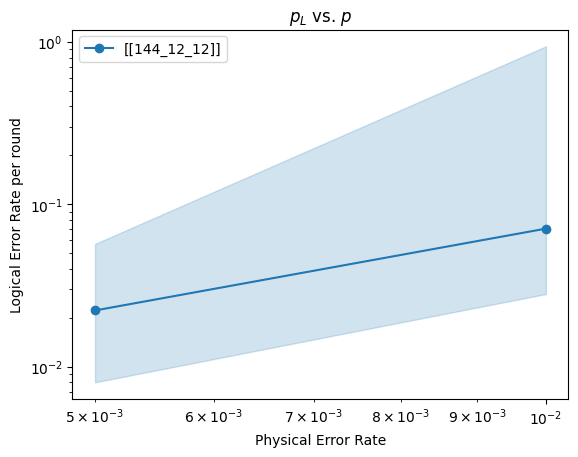

In [3]:
# Plot results:

import matplotlib.pyplot as plt
import sinter

# Plot:
collected_stats = sinter.stats_from_csv_files(f'example_stats/collected_stats.csv')

fig, ax = plt.subplots(1, 1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
)

ax.loglog()
ax.legend()
ax.set_title("$p_L$ vs. $p$")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per round");

In [4]:
# Other codes (copy and paste instead of [[30, 4, 5]] above)

# # [[48, 4, 7]] BB5 code from Ye Delfosse long chain [2503.22071] Table II
# l = 8
# m = 3
# # A = x^0 + x
# # B = x^0 + y + x^3 * y^2
# Aij = [(0, 0), (1, 0)]
# Bij = [(0, 0), (0, 1), (3, 2)]
# d = 7

# # [[108, 8, 10]] BB6 code from BB paper [2308.07915] Table III
# l = 9
# m = 6
# # A = x^3 + y + y^2
# # B = y^3 + x + x^2
# Aij = [(3, 0), (0, 1), (0, 2)]
# Bij = [(0, 3), (1, 0), (2, 0)]
# d = 10

# # [[144, 12, 12]] BB6 'gross' code from BB paper [2308.07915] Table III
# l = 12
# m = 6
# # A = x^3 + y + y^2
# # B = y^3 + x + x^2
# Aij = [(3, 0), (0, 1), (0, 2)]
# Bij = [(0, 3), (1, 0), (2, 0)]
# d = 12

# # [[288, 12, 18]] BB6 'two gross' code from BB paper [2308.07915] Table III
# l = 12
# m = 12
# # A = x^3 + y^2 + y^7
# # B = y^3 + x^1 + x^2
# Aij = [(3, 0), (0, 2), (0, 7)]
# Bij = [(0, 3), (1, 0), (2, 0)]
# d = 18